In [45]:
# Classification - Logistic Regression, KNN, Decision Tree, Random Forest
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)


In [46]:
# 0. split to train and test set
resins_df = pd.read_csv("건포도_refined.csv")
resins_df.drop("Unnamed: 0", axis=1, inplace=True)
x = resins_df.iloc[:, :-1]
y = resins_df.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=156, stratify=y)

# 0-1. label encoding for y
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

result_def_dict = {}
result_opt_dict = {}

In [47]:
# 1. Logistic Regression
## 1. with default hyperparameter
lr = LogisticRegression()
lr.fit(x_train, y_train_enc)
pred = lr.predict(x_test)
pred_proba = lr.predict_proba(x_test)

In [48]:
def display_plots(y_true, y_pred):
    # confusion matrix
	cm = confusion_matrix(y_true, y_pred)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Besni", "Kecimen"])
	disp.plot(cmap='Blues')
	plt.show()

	# roc
	fpr, tpr, thresholds = roc_curve(y_true, y_pred)
	auc = roc_auc_score(y_true, y_pred)

	plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
	plt.plot([0,1],[0,1],'k--')
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('ROC Curve')
	plt.legend()
	plt.show()

In [49]:
def get_score(y_test, y_pred):
   roc_auc = roc_auc_score(y_test, y_pred)
   accuracy = accuracy_score(y_test, y_pred)
   f1 = f1_score(y_test, y_pred)

   print("ROC AUC Score:",roc_auc)
   print("Accuracy:",accuracy)
   print("F1 Score:",f1)
   return roc_auc, accuracy, f1

def display_plots_2(model, y_true, y_pred):
   # 정확도 및 F1 계산
   accuracy = accuracy_score(y_true, y_pred)
   f1 = f1_score(y_true, y_pred)

   # 시각화
   metrics = ['Accuracy', 'F1 Score']
   scores = [accuracy, f1]

   plt.figure(figsize=(6, 4))
   bars = plt.bar(metrics, scores)

   # 각 막대 위에 점수 표시
   for bar, score in zip(bars, scores):
         yval = bar.get_height()
         plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{score:.4f}', ha='center', va='bottom')

   plt.ylim(0, 1)
   plt.title(f'{model.__class__.__name__}의 F1 및 Accuracy Score')
   plt.ylabel('Score')
   plt.show()

In [50]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def display_learning_curves(x, y, model):
	train_sizes, train_scores, val_scores = learning_curve(
		estimator=model, X=x, y=y, cv=5, scoring='accuracy'
	)

	train_mean = train_scores.mean(axis=1)
	val_mean   = val_scores.mean(axis=1)

	plt.plot(train_sizes, train_mean, label='Train score')
	plt.plot(train_sizes, val_mean, label='Validation score')
	plt.xlabel('Training size')
	plt.ylabel('Accuracy')
	plt.title('Learning Curve')
	plt.legend()
	plt.grid(True)
	plt.show()
 	# 결과 DataFrame 생성 및 반환
	result_df = pd.DataFrame({
        'Training Size': train_sizes,
        'Train Score': train_mean,
        'Validation Score': val_mean,
        'Gap': train_mean - val_mean
    })

	return result_df

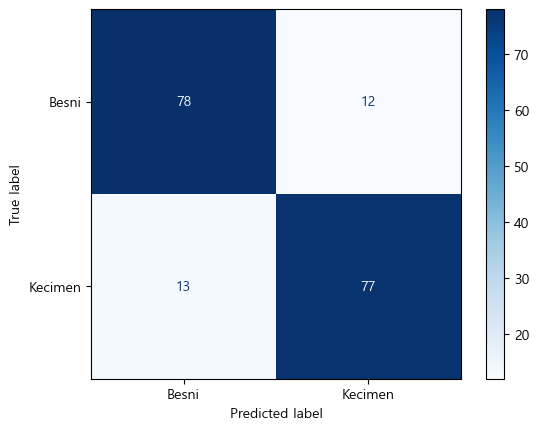

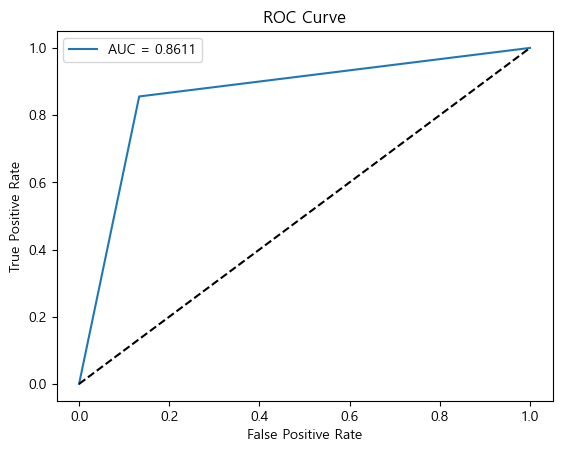

In [51]:
display_plots(y_test_enc, pred)

In [52]:
auc, acc, f1 = get_score(y_test_enc, pred)
result_def_dict["Logistic_Regression"] = {"ROC_AUC_score":auc, "Accuracy_score":acc, "F1_score": f1}

ROC AUC Score: 0.8611111111111112
Accuracy: 0.8611111111111112
F1 Score: 0.8603351955307262


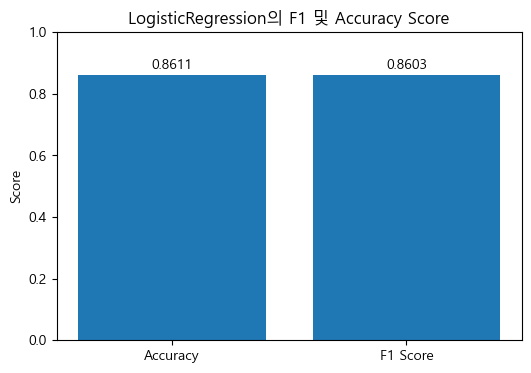

In [53]:
display_plots_2(lr, y_test_enc, pred)

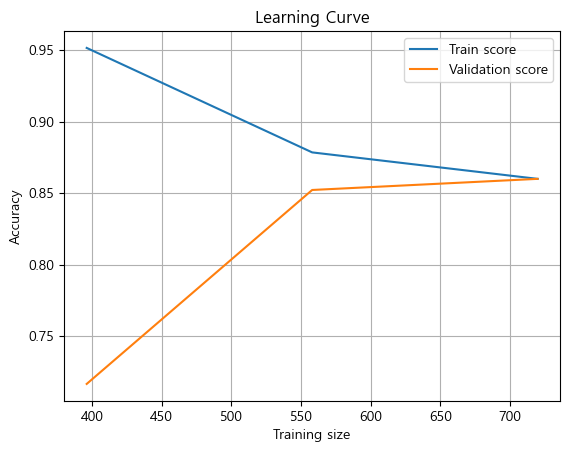

,Training Size,Train Score,Validation Score,Gap
0,72,NaN,NaN,NaN
1,234,NaN,NaN,NaN
2,396,0.951515,0.716667,0.234848
3,558,0.878495,0.852222,0.026272
4,720,0.860000,0.860000,0.000000


In [54]:
display_learning_curves(x, y, lr)

In [55]:
## 2. hyperparameter tuning
param_dict = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    "solver": ['liblinear', 'lbfgs', 'saga', 'newton-cg', 'sag'],
    "max_iter": [1, 5, 10, 50, 100]
}
lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid=param_dict, cv=5, n_jobs=-1, scoring="roc_auc")
grid.fit(x_train, y_train_enc)
print(grid.best_estimator_)


LogisticRegression(C=0.05, max_iter=1, solver='saga')


In [56]:
lr = LogisticRegression(C=10, max_iter=1, solver='saga', penalty='l1')
lr.fit(x_train, y_train_enc)
pred = lr.predict(x_test)
pred_proba = lr.predict_proba(x_test)

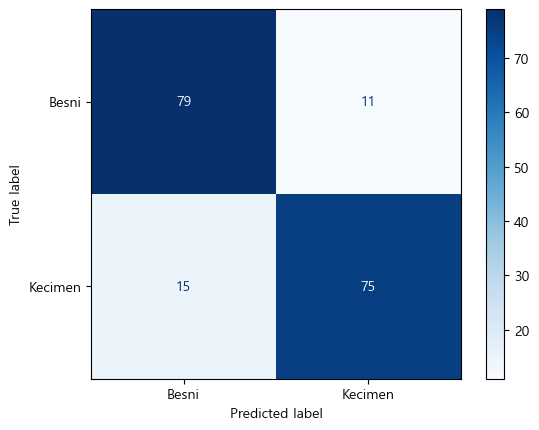

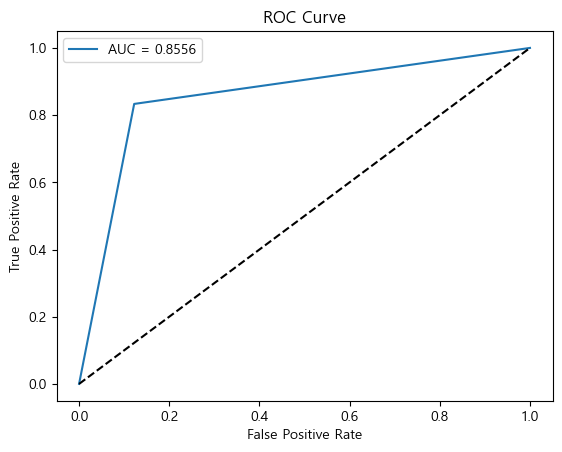

In [57]:
display_plots(y_test_enc, pred)

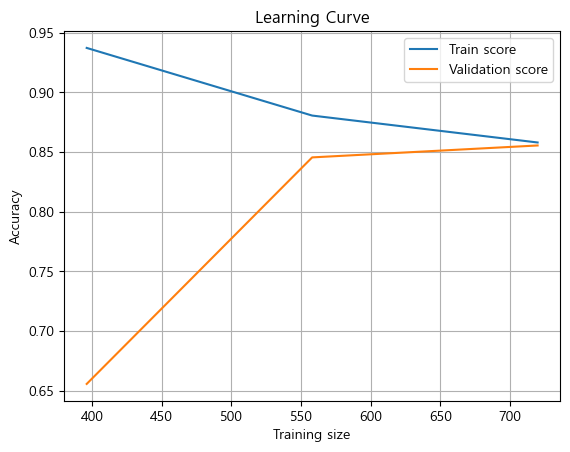

In [58]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    estimator=grid.best_estimator_, X=x, y=y, cv=5, scoring='accuracy'
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Train score')
plt.plot(train_sizes, val_mean, label='Validation score')
plt.xlabel('Training size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

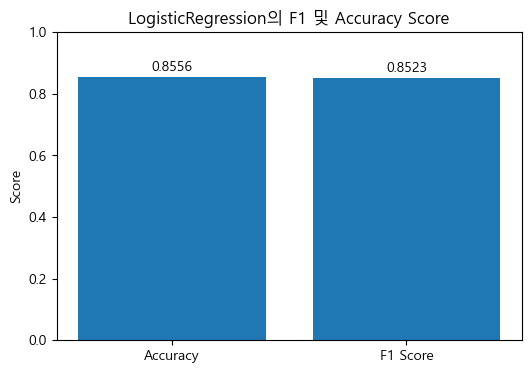

In [59]:
display_plots_2(grid.best_estimator_, y_test_enc, pred)

In [60]:
auc, acc, f1 = get_score(y_test_enc, pred)
result_opt_dict["Logistic_Regression"] = {"ROC_AUC_score":auc, "Accuracy_score":acc, "F1_score": f1}

ROC AUC Score: 0.8555555555555556
Accuracy: 0.8555555555555555
F1 Score: 0.8522727272727273


In [61]:
# 2. KNN clustering
## 2-1. with default hyperparameter
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train_enc)
pred = knn.predict(x_test)
pred_proba = knn.predict_proba(x_train)

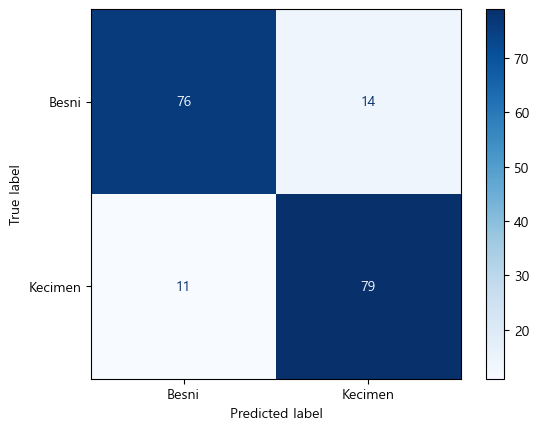

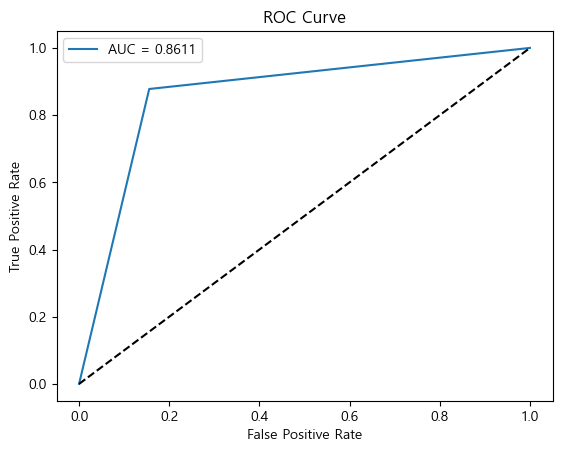

In [62]:
display_plots(y_test_enc, pred)

In [63]:
auc, acc, f1 = get_score(y_test_enc, pred)
result_def_dict["KNN"] = {"ROC_AUC_score":auc, "Accuracy_score":acc, "F1_score": f1}

ROC AUC Score: 0.861111111111111
Accuracy: 0.8611111111111112
F1 Score: 0.8633879781420765


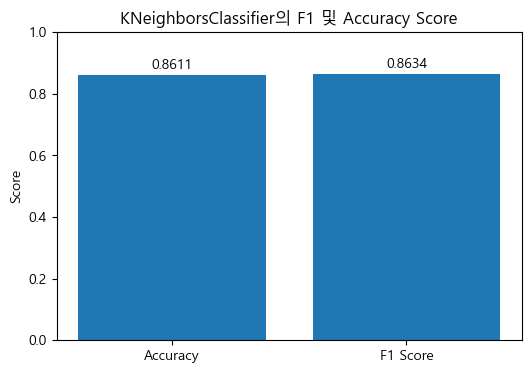

In [64]:
display_plots_2(knn, y_test_enc, pred)

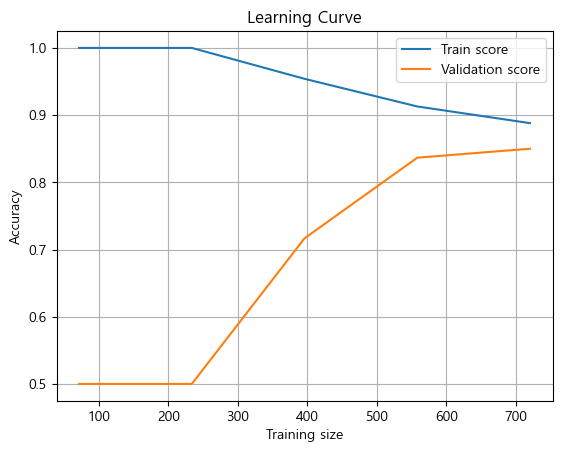

,Training Size,Train Score,Validation Score,Gap
0,72,1.000000,0.500000,0.500000
1,234,1.000000,0.500000,0.500000
2,396,0.954040,0.716667,0.237374
3,558,0.912903,0.836667,0.076237
4,720,0.888056,0.850000,0.038056


In [65]:
display_learning_curves(x, y, knn)

In [66]:
## 2-2. hyperparameter tuning
param_dict = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid=param_dict, cv=5, scoring="roc_auc")
grid.fit(x_train, y_train_enc)
print(grid.best_params_)
print(grid.best_score_)

{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
0.9094521604938273


In [67]:
param_dict = {
    'n_neighbors': [9, 97, 99, 101, 151, 201],
}
knn = KNeighborsClassifier(metric='manhattan', weights='distance')
grid = GridSearchCV(knn, param_grid=param_dict, cv=5, scoring="roc_auc")
grid.fit(x_train, y_train_enc)
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 99}
0.9171682098765432


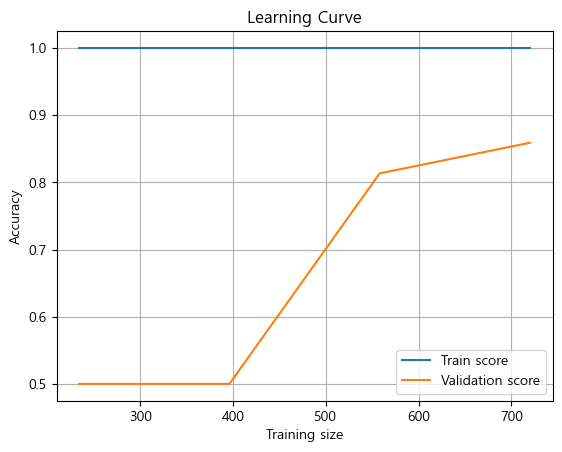

,Training Size,Train Score,Validation Score,Gap
0,72,NaN,NaN,NaN
1,234,1.0,0.500000,0.500000
2,396,1.0,0.500000,0.500000
3,558,1.0,0.813333,0.186667
4,720,1.0,0.858889,0.141111


In [68]:
display_learning_curves(x, y, grid.best_estimator_)

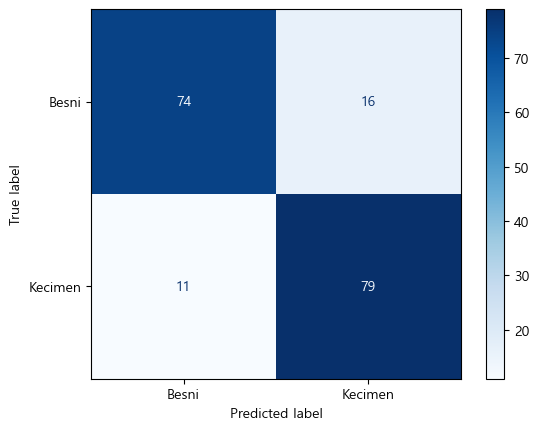

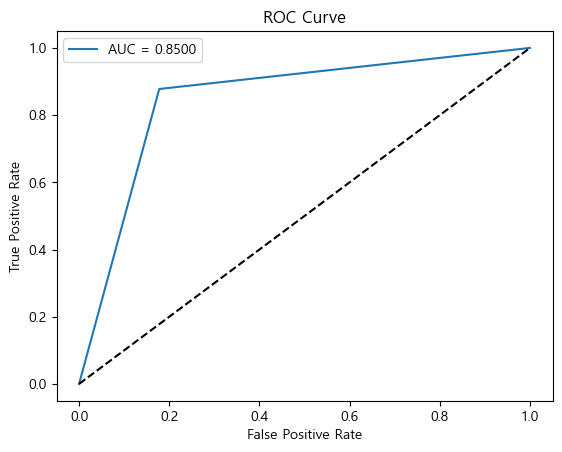

In [69]:
pred = grid.best_estimator_.predict(x_test)
pred_proba = grid.best_estimator_.predict_proba(x_test)

display_plots(y_test_enc, pred)

In [70]:
auc, acc, f1 = get_score(y_test_enc, pred)
result_opt_dict["KNN"] = {"ROC_AUC_score":auc, "Accuracy_score":acc, "F1_score": f1}

ROC AUC Score: 0.85
Accuracy: 0.85
F1 Score: 0.8540540540540541


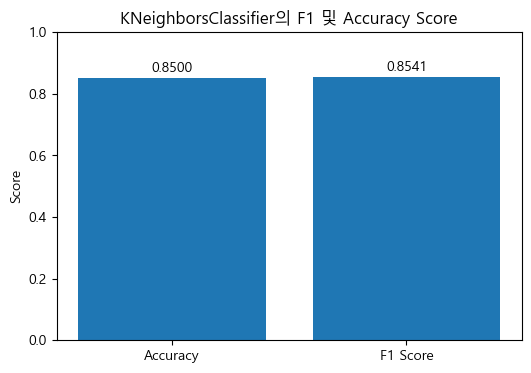

In [71]:
display_plots_2(knn, y_test_enc, pred)

In [72]:
from sklearn.model_selection import cross_val_score

tuned_model = KNeighborsClassifier(n_neighbors=99, weights='uniform', metric='euclidean')
tuned_score = cross_val_score(tuned_model, x_train, y_train_enc, cv=5).mean()

print(f"Tuned model CV score: {tuned_score:.4f}")

Tuned model CV score: 0.8444


In [73]:
# 3. decision tree
## 3-1. with default hyperparameter
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=156)
dtc.fit(x_train, y_train_enc)
pred = dtc.predict(x_test)
pred_proba = dtc.predict_proba(x_test)

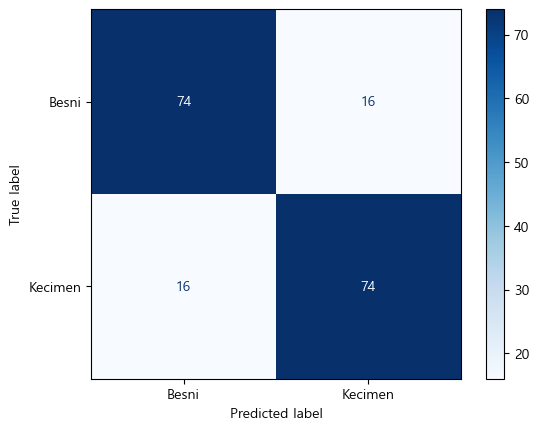

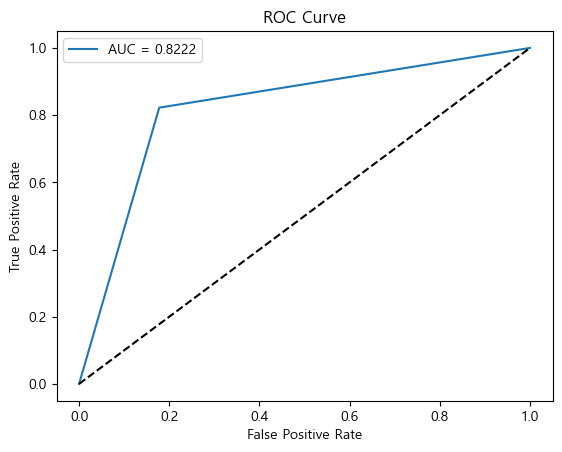

In [74]:
display_plots(y_test_enc, pred)

In [75]:
auc, acc, f1 = get_score(y_test_enc, pred)
result_def_dict["Decision_Tree"] = {"ROC_AUC_score":auc, "Accuracy_score":acc, "F1_score": f1}

ROC AUC Score: 0.8222222222222222
Accuracy: 0.8222222222222222
F1 Score: 0.8222222222222222


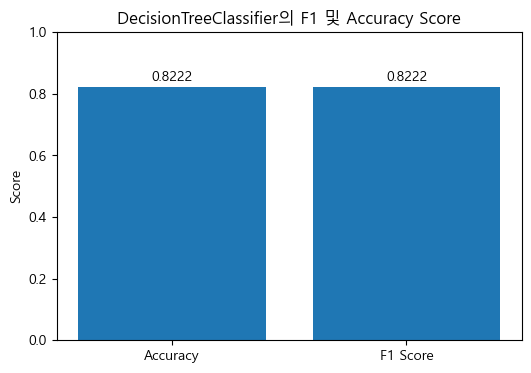

In [76]:
display_plots_2(dtc, y_test_enc, pred)

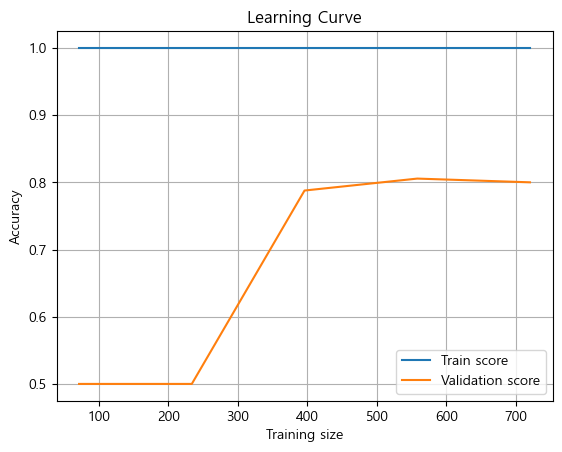

,Training Size,Train Score,Validation Score,Gap
0,72,1.0,0.500000,0.500000
1,234,1.0,0.500000,0.500000
2,396,1.0,0.787778,0.212222
3,558,1.0,0.805556,0.194444
4,720,1.0,0.800000,0.200000


In [77]:
display_learning_curves(x, y, dtc)

In [78]:
## 3-2. hyperparameter tuning

param_dict = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

dtc = DecisionTreeClassifier(random_state=156)
grid = GridSearchCV(dtc, param_grid=param_dict, cv=5, scoring="roc_auc", n_jobs=-1)
grid.fit(x_train, y_train_enc)
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.8860725308641975


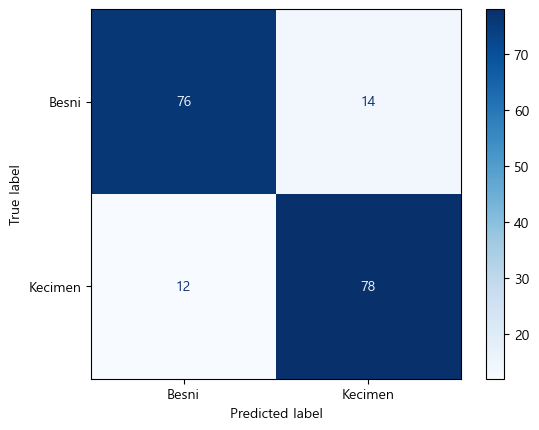

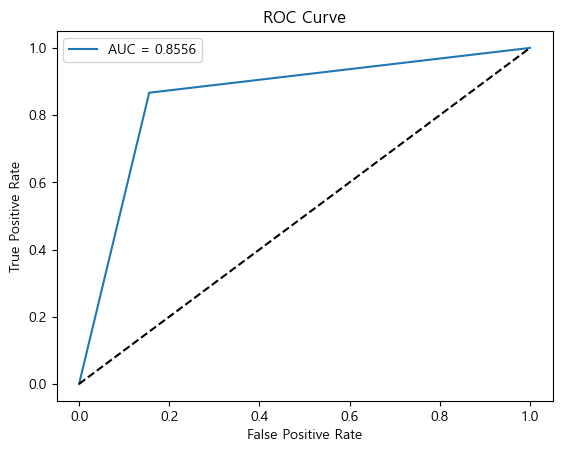

In [79]:
pred = grid.best_estimator_.predict(x_test)
pred_proba = grid.best_estimator_.predict_proba(x_test)
display_plots(y_test_enc, pred)

In [80]:
auc, acc, f1 = get_score(y_test_enc, pred)
result_opt_dict["Decision_Tree"] = {"ROC_AUC_score":auc, "Accuracy_score":acc, "F1_score": f1}

ROC AUC Score: 0.8555555555555556
Accuracy: 0.8555555555555555
F1 Score: 0.8571428571428571


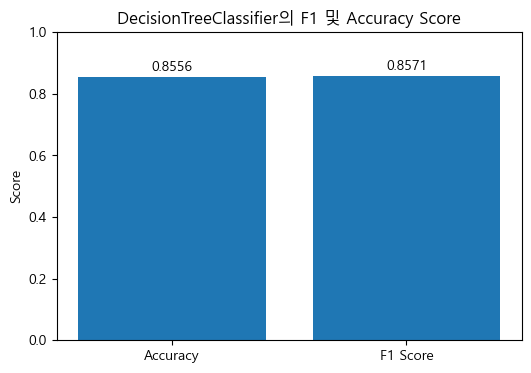

In [81]:
display_plots_2(grid.best_estimator_, y_test_enc, pred)

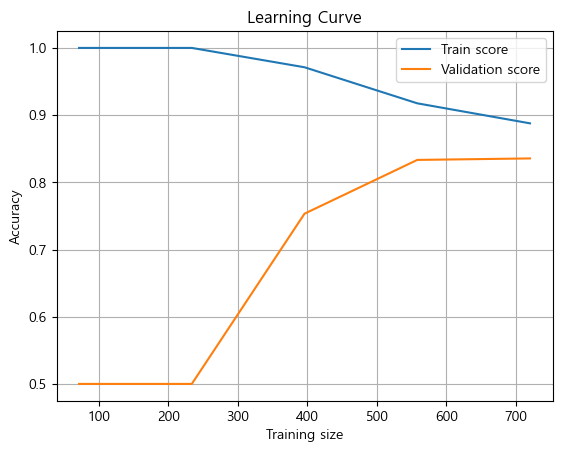

,Training Size,Train Score,Validation Score,Gap
0,72,1.000000,0.500000,0.500000
1,234,1.000000,0.500000,0.500000
2,396,0.971212,0.753333,0.217879
3,558,0.917563,0.833333,0.084229
4,720,0.887778,0.835556,0.052222


In [82]:
display_learning_curves(x, y, grid.best_estimator_)

In [83]:
# 4. random forest
## 4-1. with default parameter
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=156)
rfc.fit(x_train, y_train_enc)
pred = rfc.predict(x_test)
pred_proba = rfc.predict_proba(x_test)

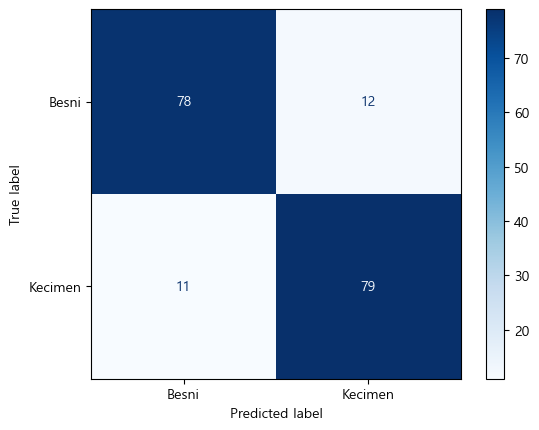

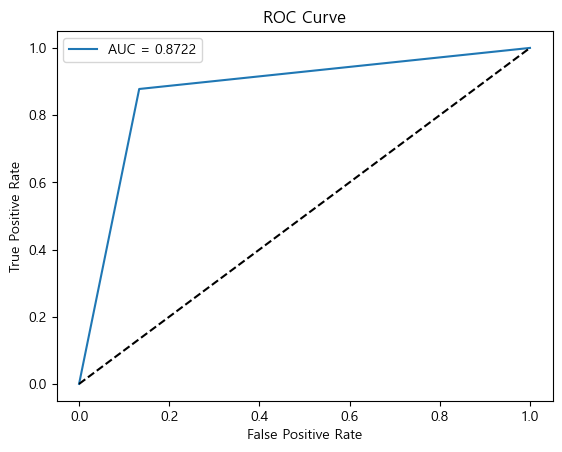

In [84]:
display_plots(y_test_enc, pred)

In [85]:
auc, acc, f1 = get_score(y_test_enc, pred)
result_def_dict["Random_Forest"] = {"ROC_AUC_score":auc, "Accuracy_score":acc, "F1_score": f1}

ROC AUC Score: 0.8722222222222222
Accuracy: 0.8722222222222222
F1 Score: 0.8729281767955801


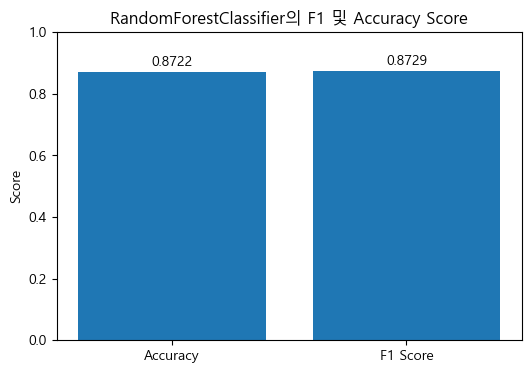

In [86]:
display_plots_2(rfc, y_test_enc, pred)

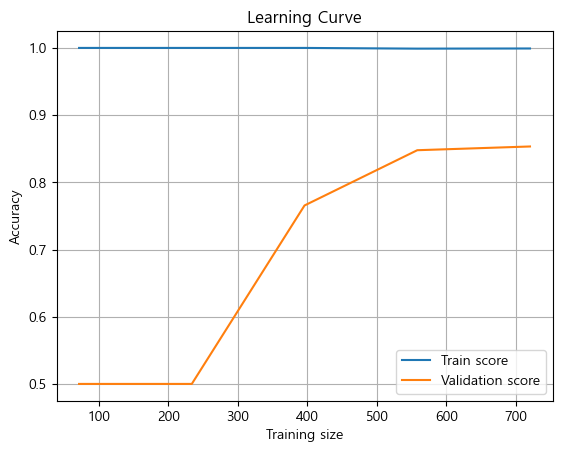

,Training Size,Train Score,Validation Score,Gap
0,72,1.000000,0.500000,0.500000
1,234,1.000000,0.500000,0.500000
2,396,1.000000,0.765556,0.234444
3,558,0.998925,0.847778,0.151147
4,720,0.999167,0.853333,0.145833


In [87]:
display_learning_curves(x, y, rfc)

In [88]:
param_grid = {
    'n_estimators': [100, 200, 300],  # 트리 개수
    'max_depth': [None, 10, 20, 30],  # 트리 최대 깊이 제한
    'min_samples_split': [2, 5, 10],  # 내부 노드 분할 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],    # 리프 노드 최소 샘플 수
    'max_features': ['sqrt', 'log2', None],  # 분할 시 고려할 특성 수
    'bootstrap': [True, False],       # 부트스트랩 샘플링 여부
    'class_weight': [None, 'balanced']  # 클래스 불균형 처리 여부
}

rfc = RandomForestClassifier(random_state=156)
grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid.fit(x_train, y_train_enc)
print(grid.best_params_)
print(grid.best_score_)

{'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.9130594135802468


In [89]:
best_rfc = RandomForestClassifier(bootstrap=True, class_weight=None, max_depth=10, max_features='sqrt', min_samples_split=2, min_samples_leaf=1, n_estimators=100, random_state=156)
best_rfc.fit(x_train, y_train_enc)

RandomForestClassifier(max_depth=10, random_state=156)

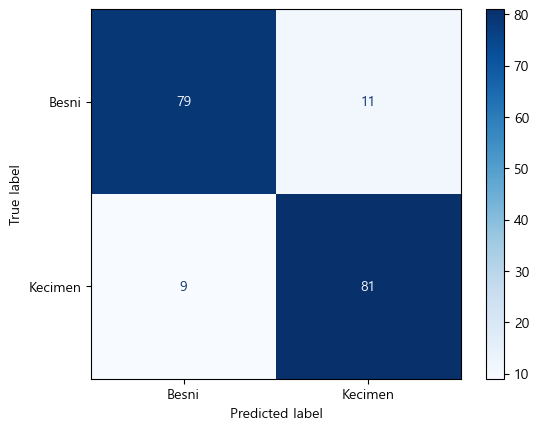

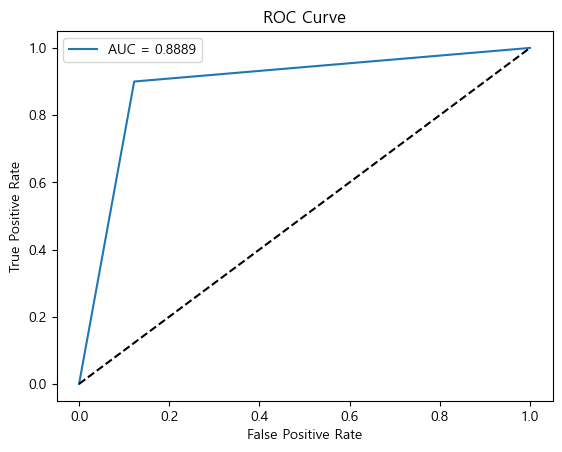

In [90]:
pred = best_rfc.predict(x_test)
pred_proba = best_rfc.predict_proba(x_test)
display_plots(y_test_enc, pred)

In [91]:
auc, acc, f1 = get_score(y_test_enc, pred)
result_opt_dict["Random_Forest"] = {"ROC_AUC_score":auc, "Accuracy_score":acc, "F1_score": f1}

ROC AUC Score: 0.8888888888888888
Accuracy: 0.8888888888888888
F1 Score: 0.8901098901098901


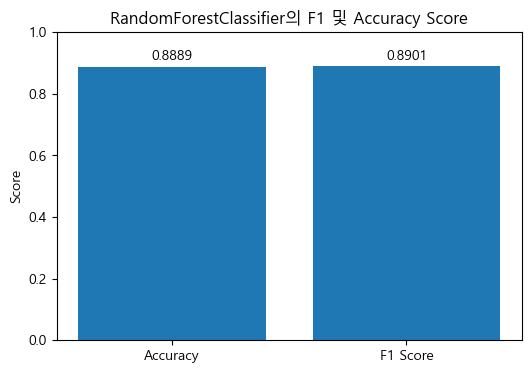

In [92]:
display_plots_2(best_rfc, y_test_enc, pred)

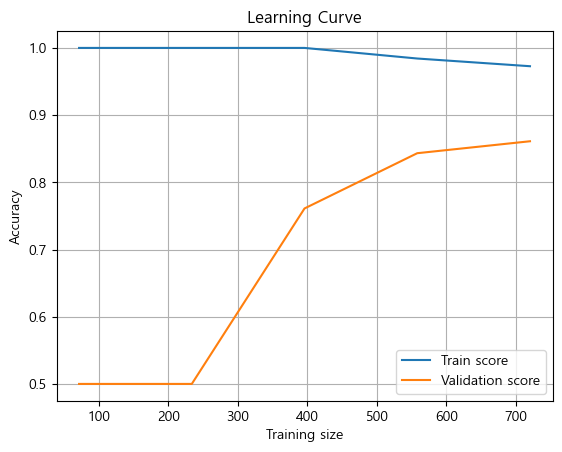

,Training Size,Train Score,Validation Score,Gap
0,72,1.000000,0.500000,0.500000
1,234,1.000000,0.500000,0.500000
2,396,1.000000,0.761111,0.238889
3,558,0.984229,0.843333,0.140896
4,720,0.972778,0.861111,0.111667


In [93]:
display_learning_curves(x, y, best_rfc)

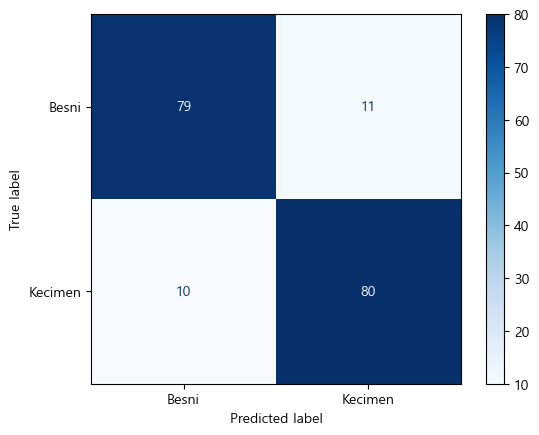

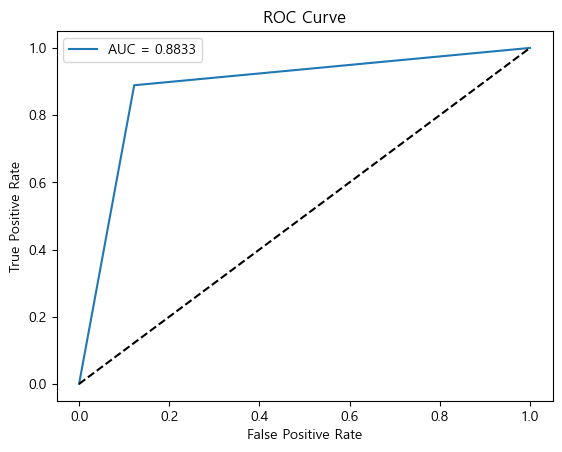

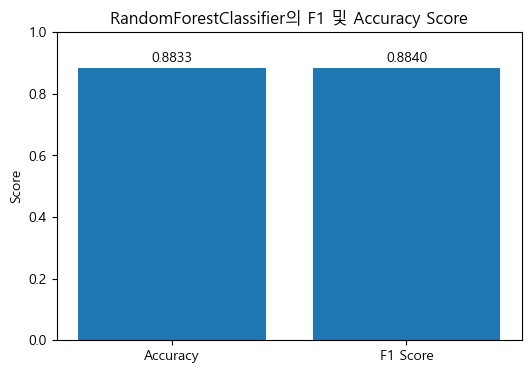

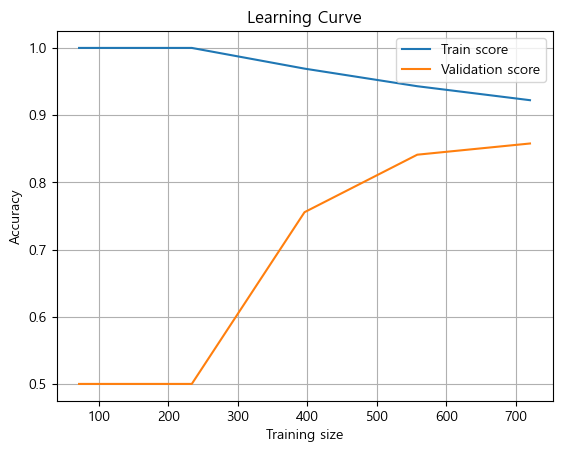

,Training Size,Train Score,Validation Score,Gap
0,72,1.000000,0.500000,0.500000
1,234,1.000000,0.500000,0.500000
2,396,0.969192,0.755556,0.213636
3,558,0.943011,0.841111,0.101900
4,720,0.922222,0.857778,0.064444


In [94]:
# resolving overfitting
from sklearn.ensemble import RandomForestClassifier
fixed_rfc_1 = RandomForestClassifier(bootstrap=True, class_weight=None, max_depth=10, max_features='sqrt', min_samples_split=3, min_samples_leaf=3, n_estimators=100, random_state=156)
fixed_rfc_1.fit(x_train, y_train_enc)
pred = fixed_rfc_1.predict(x_test)
display_plots(y_test_enc, pred)
display_plots_2(fixed_rfc_1, y_test_enc, pred)
display_learning_curves(x, y, fixed_rfc_1)

In [95]:
auc, acc, f1 = get_score(y_test_enc, pred)
result_opt_dict["Random_Forest"] = {"ROC_AUC_score":auc, "Accuracy_score":acc, "F1_score": f1}

ROC AUC Score: 0.8833333333333333
Accuracy: 0.8833333333333333
F1 Score: 0.8839779005524862


In [96]:
from pprint import pprint
pprint(result_def_dict)
pprint(result_opt_dict)

{'Decision_Tree': {'Accuracy_score': 0.8222222222222222,
                   'F1_score': 0.8222222222222222,
                   'ROC_AUC_score': 0.8222222222222222},
 'KNN': {'Accuracy_score': 0.8611111111111112,
         'F1_score': 0.8633879781420765,
         'ROC_AUC_score': 0.861111111111111},
 'Logistic_Regression': {'Accuracy_score': 0.8611111111111112,
                         'F1_score': 0.8603351955307262,
                         'ROC_AUC_score': 0.8611111111111112},
 'Random_Forest': {'Accuracy_score': 0.8722222222222222,
                   'F1_score': 0.8729281767955801,
                   'ROC_AUC_score': 0.8722222222222222}}
{'Decision_Tree': {'Accuracy_score': 0.8555555555555555,
                   'F1_score': 0.8571428571428571,
                   'ROC_AUC_score': 0.8555555555555556},
 'KNN': {'Accuracy_score': 0.85,
         'F1_score': 0.8540540540540541,
         'ROC_AUC_score': 0.85},
 'Logistic_Regression': {'Accuracy_score': 0.8555555555555555,
                  

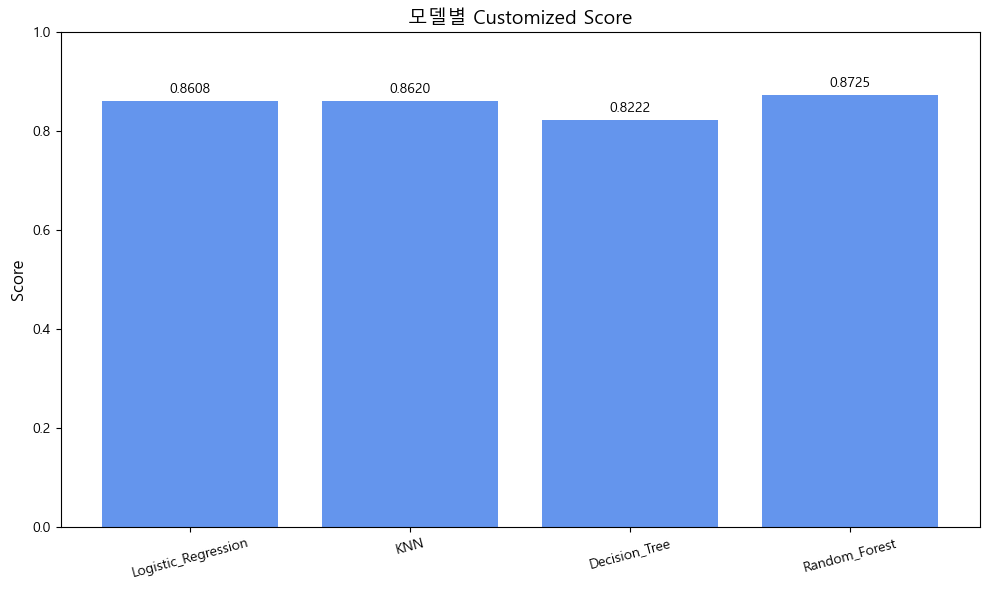

In [101]:
# score = 0.4 * f1 + 0.4 * auc + 0.2 * accuracy
def calculate_custom_score(auc, accuracy, f1):
    return 0.4 * f1 + 0.4 * auc + 0.2 * accuracy

scores = {}
for model, metrics in result_def_dict.items():
    score = calculate_custom_score(metrics["ROC_AUC_score"], metrics["Accuracy_score"], metrics["F1_score"])
    scores[model] = score
    
# 막대그래프 시각화
models = list(scores.keys())
score_values = list(scores.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(models, score_values, color='cornflowerblue')
plt.title("모델별 Customized Score", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)

# 막대 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

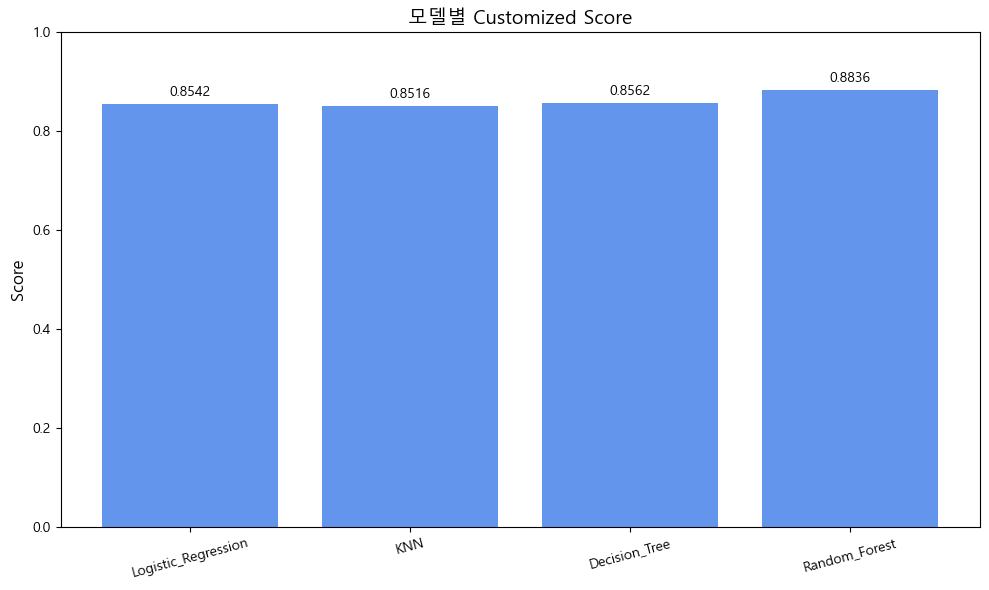

In [102]:

scores = {}
for model, metrics in result_opt_dict.items():
    score = calculate_custom_score(metrics["ROC_AUC_score"], metrics["Accuracy_score"], metrics["F1_score"])
    scores[model] = score
    
# 막대그래프 시각화
models = list(scores.keys())
score_values = list(scores.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(models, score_values, color='cornflowerblue')
plt.title("모델별 Customized Score", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1)

# 막대 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()